# Chest X-Ray Images (Pneumonia)

### Initial Steps

In [1]:
# Installs tensorflow if there is not installed already.
# !pip install tensorflow

In [2]:
# Ignores warnings if continuously showed up.
import warnings
warnings.filterwarnings(action = "once")

#### Import common libraries

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random, itertools, os, datetime

from importlib import reload

<frozen importlib._bootstrap>:488: DeprecationWarning: Type google.protobuf.pyext._message.ScalarMapContainer uses PyType_Spec with a metaclass that has custom tp_new. This is deprecated and will no longer be allowed in Python 3.14.
<frozen importlib._bootstrap>:488: DeprecationWarning: Type google.protobuf.pyext._message.MessageMapContainer uses PyType_Spec with a metaclass that has custom tp_new. This is deprecated and will no longer be allowed in Python 3.14.


#### Import helper functions

In [4]:
# Imports helper_functions module.
import extras.helper_functions as hf
from importlib import reload
reload(hf)

<module 'extras.helper_functions' from 'D:\\Desktop\\Projects\\Machine and Deep Learning\\simulations-ml-dl\\Chest X-Ray - Pneumonia\\extras\\helper_functions.py'>

#### Download image dataset

In [5]:
import kagglehub, shutil
from pathlib import Path

current_directory = str(Path.cwd())
print(f"Current Directory: {current_directory}\n")

if not os.path.isdir('dataset'):
    # Downloads dataset from kaggle.
    dataset_path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
    # Makes a copy of dataset from "cache" directory to current location, into "dataset" separated directory.
    shutil.copytree(dataset_path + "\\chest_xray\\chest_xray", current_directory + "\\dataset")
    # Removes the directory where dataset first downloaded. Kagglehub downloads the files into "\\.cache" directory. 
    # If we won't to delete root ("\\kagglehub") directory, in case there are more datasets into it, then a specific path of directory must be changed.
    shutil.rmtree(str(os.path.expanduser('~')) + "\\.cache\\kagglehub")
dataset_path = current_directory + "\\dataset"
print(f"Dataset Path: {dataset_path}\n")

Current Directory: D:\Desktop\Projects\Machine and Deep Learning\simulations-ml-dl\Chest X-Ray - Pneumonia

Dataset Path: D:\Desktop\Projects\Machine and Deep Learning\simulations-ml-dl\Chest X-Ray - Pneumonia\dataset



In [6]:
# Getting a first look of distribution of images and categories of them. 
root_path = "dataset"
hf.walk_through_dir(dir_path = root_path)

There are 3 directories and 1 images in 'dataset'.
There are 2 directories and 1 images in 'dataset\test'.
There are 0 directories and 234 images in 'dataset\test\NORMAL'.
There are 0 directories and 390 images in 'dataset\test\PNEUMONIA'.
There are 2 directories and 1 images in 'dataset\train'.
There are 0 directories and 1342 images in 'dataset\train\NORMAL'.
There are 0 directories and 3876 images in 'dataset\train\PNEUMONIA'.
There are 2 directories and 1 images in 'dataset\val'.
There are 0 directories and 9 images in 'dataset\val\NORMAL'.
There are 0 directories and 9 images in 'dataset\val\PNEUMONIA'.


In [7]:
data_dir = Path("dataset/train")
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
class_names = np.delete(class_names, np.argwhere(class_names == '.DS_Store'))
print(class_names)

['NORMAL' 'PNEUMONIA']


#### Visualisation of image

['NORMAL2-IM-0456-0001.jpeg']

Image shape: (1079, 1368)


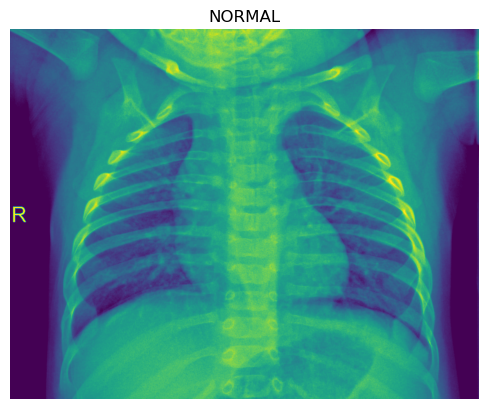

In [8]:
img = hf.view_random_image("dataset/train/", random.choice(class_names))

In [9]:
print(f"Shape of image is => {img.shape}")
# Normalization of images values.
img = img / 255.
img

Shape of image is => (1079, 1368)


array([[0.4627451 , 0.45098039, 0.45490196, ..., 0.43921569, 0.4627451 ,
        0.49803922],
       [0.45882353, 0.46666667, 0.4627451 , ..., 0.42745098, 0.45490196,
        0.49411765],
       [0.43529412, 0.45490196, 0.45490196, ..., 0.43529412, 0.45882353,
        0.49803922],
       ...,
       [0.        , 0.        , 0.        , ..., 0.03921569, 0.0627451 ,
        0.08235294],
       [0.        , 0.        , 0.        , ..., 0.03529412, 0.05882353,
        0.07843137],
       [0.        , 0.        , 0.        , ..., 0.03529412, 0.05490196,
        0.07843137]])

### Building Artificial Models

#### Initial-Basic Model

In [10]:
from tensorflow.keras.utils import image_dataset_from_directory
# Sets random seed.
tf.random.set_seed(42)

train_dir = "dataset/train"
val_dir = "dataset/val"
test_dir = "dataset/test"

train_dataset = image_dataset_from_directory(directory = train_dir,
                                             labels = 'inferred',
                                             label_mode = 'binary',
                                             batch_size = 32,
                                             image_size = (256, 256),
                                             seed = 42)
val_dataset = image_dataset_from_directory(directory = val_dir,
                                           labels = 'inferred',
                                           label_mode = 'binary',
                                           image_size = (256, 256),
                                           seed = 42)
test_dataset = image_dataset_from_directory(directory = test_dir,
                                            labels = 'inferred',
                                            label_mode = 'binary',
                                            batch_size = 32,
                                            image_size = (256, 256),
                                            seed = 42)

Found 5216 files belonging to 2 classes.
AttributeError: module 'ml_dtypes' has no attribute 'float4_e2m1fn'
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [11]:
# Builds CNN model.
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape = (256, 256, 3)),
    tf.keras.layers.Conv2D(filters = 10, 
                           kernel_size = 3,
                           activation = "relu"),
    tf.keras.layers.Conv2D(10, 3, activation = "relu"),
    tf.keras.layers.MaxPooling2D(pool_size = 2, padding = "valid"),
    tf.keras.layers.Conv2D(10, 3, activation = "relu"),
    tf.keras.layers.Conv2D(10, 3, activation = "relu"),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation = "sigmoid")
])

In [12]:
# Compiles CNN.
model_1.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

# Fitting CNN.
history_1 = model_1.fit(train_dataset, 
                        epochs = 5, 
                        steps_per_epoch = len(train_dataset), 
                        validation_data = val_dataset, 
                        validation_steps = len(val_dataset))

Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 22s 130ms/step - accuracy: 0.7873 - loss: 6.2511 - val_accuracy: 0.8125 - val_loss: 0.3687
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9582 - loss: 0.1158 - val_accuracy: 0.7500 - val_loss: 0.5644
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.9771 - loss: 0.0717 - val_accuracy: 0.8750 - val_loss: 0.1963
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 23s 138ms/step - accuracy: 0.9887 - loss: 0.0366 - val_accuracy: 0.8750 - val_loss: 0.2797
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 22s 132ms/step - accuracy: 0.9966 - loss: 0.0184 - val_accuracy: 0.8750 - val_loss: 0.2331


In [13]:
# Checking out the layers in our model.
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 10)   │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 252, 252, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 126, 126, 10)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 124, 124, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 122, 122, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 61, 61, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 37210)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        37,211 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,665 (471.35 KB)

 Trainable params: 40,221 (157.11 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 80,444 (314.24 KB)

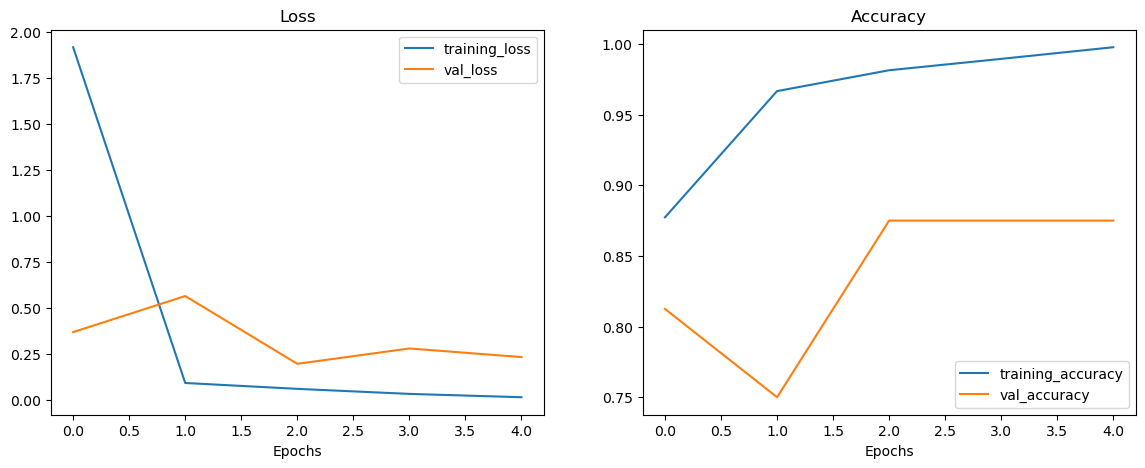

In [14]:
# Plots the training curves.
hf.plot_loss_curves(history = history_1)

In [15]:
# Getting the actual values of target categories.
y_true = []
for images, labels in test_dataset:
    y_true.extend(labels.numpy())
y_true = np.array(y_true).astype(int)

In [16]:
# Makes predictions and converts the results to 0 or 1, representing the category of each image model predicts that belongs.
y_pred = model_1.predict(test_dataset)
y_pred = (y_pred > 0.5).astype(int)

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


In [17]:
# Results of model_1.
results_model_1 = hf.calculate_binary_classification_metrics(y_true, y_pred)
results_model_1

,accuracy (%),f1-Score,precision,recall
0,59.0,0.53,0.53,0.59


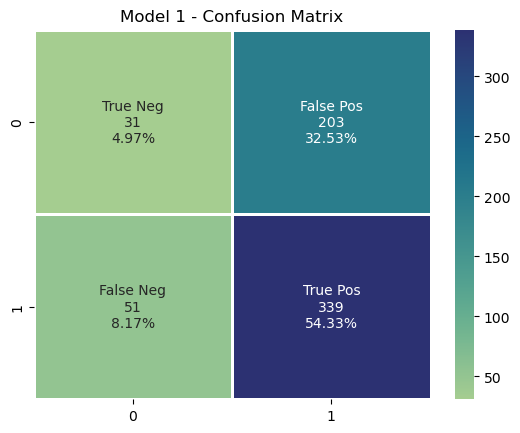

In [18]:
# Confusion Matric of model_1.
hf.custom_confusion_matrix(y_true, y_pred, title = "Model 1 - Confusion Matrix")

* As it stands, the basic convolution model succeed until 62% accuracy only, falling to categorize correctly (in most occasions) images of "NORMAL" condition of patient.
* So, it is necessary to improve our model to generalize better, changing the construction of layer and / or adding transfer learning.

#### Augmented Implementation

* In this step, image augmentation will be implemented at training dataset images, in order to trying model to understand better if image represent healthy or inflicted person.

In [19]:
# Creating a Sequential Model for augmentation (Augmented Image Generator).
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1/255.),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(height_factor = 0.3),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomTranslation(height_factor = 0.1, width_factor = 0.1)
])

In [20]:
# Mapping the data augmentation on training images creating new training dataset with augmented images.
train_dataset_augmented = train_dataset.map(lambda x, y: (data_augmentation(x, training = True), y))

model_2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (256, 256, 3)),
    tf.keras.layers.Conv2D(filters = 10, 
                           kernel_size = 3,
                           activation = "relu"),
    tf.keras.layers.Conv2D(10, 3, activation = "relu"),
    tf.keras.layers.MaxPooling2D(pool_size = 2, padding = "valid"),
    tf.keras.layers.Conv2D(10, 3, activation = "relu"),
    tf.keras.layers.Conv2D(10, 3, activation = "relu"),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation = "sigmoid")    
])

# Compiles CNN.
model_2.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

# Fitting CNN.
history_2 = model_2.fit(train_dataset_augmented, 
                        epochs = 5, 
                        steps_per_epoch = len(train_dataset), 
                        validation_data = val_dataset, 
                        validation_steps = len(val_dataset))

Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 61s 369ms/step - accuracy: 0.7285 - loss: 0.5631 - val_accuracy: 0.5625 - val_loss: 167.3389
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 60s 366ms/step - accuracy: 0.7725 - loss: 0.4727 - val_accuracy: 0.6250 - val_loss: 178.2288
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 60s 365ms/step - accuracy: 0.8263 - loss: 0.3937 - val_accuracy: 0.6250 - val_loss: 156.1618
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 60s 366ms/step - accuracy: 0.8278 - loss: 0.4053 - val_accuracy: 0.6250 - val_loss: 83.8738
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 60s 366ms/step - accuracy: 0.8458 - loss: 0.3572 - val_accuracy: 0.5000 - val_loss: 1193.1289


In [21]:
model_2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 254, 254, 10)   │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 252, 252, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 126, 126, 10)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 124, 124, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 122, 122, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 61, 61, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 37210)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        37,211 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,665 (471.35 KB)

 Trainable params: 40,221 (157.11 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 80,444 (314.24 KB)

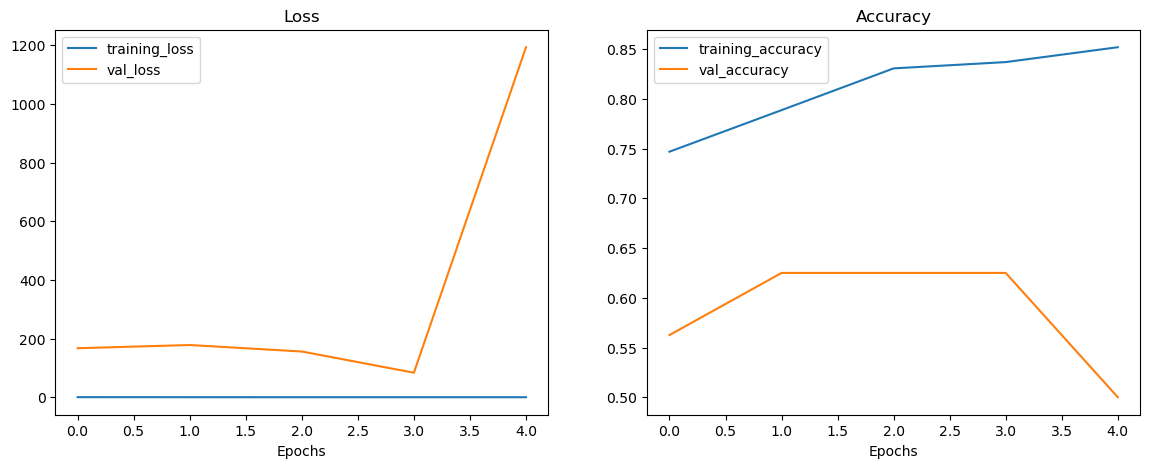

In [22]:
hf.plot_loss_curves(history = history_2)

In [23]:
y_pred = model_2.predict(test_dataset)
y_pred = (y_pred > 0.5).astype(int)

results_model_2 = hf.calculate_binary_classification_metrics(y_true, y_pred)
results_model_2

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


C:\Users\skyli\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,accuracy (%),f1-Score,precision,recall
0,38.0,0.2,0.14,0.38


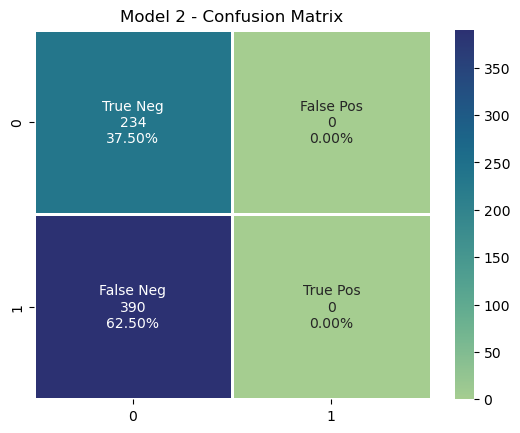

In [24]:
hf.custom_confusion_matrix(y_true, y_pred, title = "Model 2 - Confusion Matrix")

* Despite the addition of image augmentation on model, it does not help to improve the accuracy of predictions extrapolating the same results.
* Since, the difficulties in both cases are not avoided, at least in accaptable or reasonable level, the next step is to implement the Tranfer Learning.

#### Transfer Learning